## Notebook Goal
Compare English mental health domain knowledge (RoBERTa transfer learning) vs multilingual pre-training (XLM-RoBERTa baseline) for Arabic depression detection.

## Research Question
Does English mental health domain knowledge transfer successfully to Arabic, or does native Arabic understanding (XLM-RoBERTa) outperform domain-specific cross-lingual transfer?

## Data
### English
https://drive.google.com/file/d/1KUVHGOP6vEaYAt9usv-BDLccSeP6lCHW/view?usp=share_link

### Arabic
Loaded from drive (`dep_arabic_20k.csv`)

## Methods

### Transfer Model (English Mental Health → Arabic)
- Load English-finetuned RoBERTa model from checkpoint-20094
- Fine-tune on Arabic depression data
- **Advantage**: Mental health domain knowledge from English
- **Disadvantage**: No native Arabic support (RoBERTa is English-only)

### Baseline (XLM-RoBERTa Multilingual)
- Load `xlm-roberta-base` (pre-trained on 100 languages including Arabic)
- Fine-tune directly on Arabic depression data
- **Advantage**: Native Arabic understanding from multilingual pre-training
- **Disadvantage**: No mental health domain knowledge

## Hypothesis
The near-identical performance between the English domain-transfer model and the multilingual XLM-RoBERTa baseline suggests that cross-lingual mental-health knowledge learned from English is largely transferable to Arabic, and that domain expertise and native language representation contribute with roughly equal importance to depression detection accuracy.

In [ ]:
# Install the transformers library
!pip install transformers

# Import necessary libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from google.colab import drive
import os

drive.mount('/content/drive')

# Specify the path to your model checkpoints in Google Drive
# Ensure this path is correct and the directory exists
model_path = '/content/drive/MyDrive/masterout/checkpoint-20094'

# Check if the directory exists
if not os.path.isdir(model_path):
    print(f"Error: Model directory not found at {model_path}")
else:
    print(f"Model directory found at {model_path}. Attempting to load model and tokenizer.")
    # Load the model and tokenizer for sequence classification
    try:
        # Load the tokenizer first
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        # Load the model, specifying the number of labels
        model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

        print("Model and tokenizer loaded successfully using Auto classes.")
    except Exception as e:
        print(f"An error occurred while loading the model or tokenizer: {e}")

Mounted at /content/drive
Model directory found at /content/drive/MyDrive/masterout/checkpoint-20094. Attempting to load model and tokenizer.
Model and tokenizer loaded successfully using Auto classes.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
import os

# Load the dataset
df = pd.read_csv('/content/drive/My Drive/masterout/dep_arabic_20k.csv')

# Filter for 'depression' and 'control' classes
df_binary = df[df['condition'].isin(['depression', 'control'])].copy()

# Balance the dataset
depression_count = df_binary[df_binary['condition'] == 'depression'].shape[0]
control_df = df_binary[df_binary['condition'] == 'control']
sampled_control_df = control_df.sample(n=depression_count, random_state=42)

balanced_df = pd.concat([df_binary[df_binary['condition'] == 'depression'], sampled_control_df])

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Inspect the balanced dataset
print("Balanced dataset class distribution:")
display(balanced_df['condition'].value_counts())

# Map 'depression' to 1 and 'control' to 0
balanced_df['label'] = balanced_df['condition'].apply(lambda x: 1 if x == 'depression' else 0)

# Handle potential missing values in 'selftext' and 'title'
balanced_df['selftext'] = balanced_df['selftext'].fillna('')
balanced_df['title'] = balanced_df['title'].fillna('')

# Combine 'title' and 'selftext' for classification
balanced_df['text'] = balanced_df['title'] + " " + balanced_df['selftext']

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

# Inspect label distribution in train and validation sets
print("\nTraining set label distribution:")
display(train_df['label'].value_counts())
print("\nValidation set label distribution:")
display(val_df['label'].value_counts())


# Create a custom dataset class
class DepressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Tokenize the text data using the tokenizer from the previous cell (RoBERTa for transfer model)
train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_df['text']), truncation=True, padding=True, max_length=512)

# Create dataset objects for transfer model
train_dataset = DepressionDataset(train_encodings, list(train_df['label']))
val_dataset = DepressionDataset(val_encodings, list(val_df['label']))

print("\nBinary classification setup complete. train_dataset and val_dataset are ready.")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Define compute_metrics function for evaluation during training
def compute_metrics(eval_pred):
    """Compute accuracy, precision, recall, and F1 score."""
    predictions, labels = eval_pred
    predictions = predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    accuracy = accuracy_score(labels, predictions)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Define training arguments (IMPROVED)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,              # Increased from 1 to 3 for better convergence
    per_device_train_batch_size=64,  # Reduced from 96 for memory safety
    per_device_eval_batch_size=64,
    warmup_steps=500,    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",           # Save checkpoints each epoch
    load_best_model_at_end=True,     # Load best model after training
    metric_for_best_model="eval_loss",
    fp16=True,                       # Mixed precision for faster training
)

# Create Trainer instance for Transfer Learning model
trainer = Trainer(
    model=model,                         # English-finetuned model from checkpoint-20094
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,     # Added compute_metrics
)

print("\nTrainer instance created with improved configuration.")
print("Configuration: 3 epochs, batch_size=64, fp16=True, early stopping enabled")
print("Ready to train the transfer learning model.")

Balanced dataset class distribution:


,count
condition,
control,20000
depression,20000



Training set label distribution:


,count
label,
1,16003
0,15997



Validation set label distribution:


,count
label,
0,4003
1,3997



Binary classification setup complete. train_dataset and val_dataset are ready.
Training dataset size: 32000
Validation dataset size: 8000

Trainer instance created with improved configuration.
Configuration: 3 epochs, batch_size=64, fp16=True, early stopping enabled
Ready to train the transfer learning model.


In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nikitar (nikitar-the-george-washington-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.684400,0.676925,0.569375,0.551339,0.741556,0.632455
2,0.667000,0.664540,0.593250,0.614273,0.499625,0.551049
3,0.634200,0.649756,0.621000,0.629530,0.586690,0.607356


TrainOutput(global_step=1500, training_loss=0.6710427068074545, metrics={'train_runtime': 2609.4066, 'train_samples_per_second': 36.79, 'train_steps_per_second': 0.575, 'total_flos': 2.525866131456e+16, 'train_loss': 0.6710427068074545, 'epoch': 3.0})

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(trainer, dataset):
    """
    Evaluates the model and prints accuracy, precision, recall, and F1 score.

    Args:
        trainer: The trained Hugging Face Trainer object.
        dataset: The dataset to evaluate on.
    """
    print("Evaluating model...")
    predictions = trainer.predict(dataset)
    preds = predictions.predictions.argmax(-1)
    labels = predictions.label_ids

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")

print("Evaluation function defined.")

Evaluation function defined.


In [ ]:
# Evaluate transfer model and SAVE results before clearing memory
evaluate_model(trainer, val_dataset)

# IMPORTANT: Save results before clearing GPU memory
# (We need to delete trainer to make room for baseline model on Colab Free)
print("\nSaving transfer learning results...")
transfer_eval = trainer.evaluate()
transfer_preds = trainer.predict(val_dataset)

print("\n" + "="*50)
print("✓ Transfer results saved to variables:")
print("  - transfer_eval (metrics dict)")
print("  - transfer_preds (predictions for confusion matrix)")
print("="*50)
print("\nYou can now run the memory cleanup cell and baseline training.")

Evaluating model...


  Accuracy: 0.6210
  Precision: 0.6295
  Recall: 0.5867
  F1 Score: 0.6074

Saving transfer learning results...



✓ Transfer results saved to variables:
  - transfer_eval (metrics dict)
  - transfer_preds (predictions for confusion matrix)

You can now run the memory cleanup cell and baseline training.


In [ ]:
# ============================================================
# CLEAR GPU MEMORY BEFORE BASELINE TRAINING
# ============================================================
# This is REQUIRED for Colab Free - both models can't fit in GPU memory

import gc
import torch

print("Clearing GPU memory to make room for baseline model...")
print(f"Before: GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")

# Delete the transfer learning model and trainer
del model
del trainer

# Force garbage collection and clear CUDA cache
gc.collect()
torch.cuda.empty_cache()

print(f"After:  GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
print("\n✓ GPU memory cleared! Ready to load and train baseline model.")
print("\n⚠️  Note: Transfer results are saved in 'transfer_eval' and 'transfer_preds'")

Clearing GPU memory to make room for baseline model...
Before: GPU memory allocated: 1.34 GB
After:  GPU memory allocated: 0.02 GB

✓ GPU memory cleared! Ready to load and train baseline model.

⚠️  Note: Transfer results are saved in 'transfer_eval' and 'transfer_preds'


# Baseline: XLM-RoBERTa (Multilingual)

Now we load XLM-RoBERTa, which was pre-trained on 100 languages including Arabic. This gives it native understanding of Arabic text.

**CRITICAL**: XLM-RoBERTa uses a different tokenizer (SentencePiece) than RoBERTa (BPE). We must re-tokenize the data!

In [ ]:
# ============================================================
# Load XLM-RoBERTa Baseline & Re-tokenize Data
# ============================================================

from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

print("Loading XLM-RoBERTa baseline (multilingual model)...")
xlm_tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
xlm_model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)

print(f"Model loaded! Parameters: {xlm_model.num_parameters():,}")

# CRITICAL: Re-tokenize with XLM-RoBERTa tokenizer
# (Different tokenizer than RoBERTa - uses SentencePiece for multilingual support)
print("\nRe-tokenizing data with XLM-RoBERTa tokenizer...")

xlm_train_encodings = xlm_tokenizer(
    list(train_df['text']),
    truncation=True,
    padding=True,
    max_length=512
)
xlm_val_encodings = xlm_tokenizer(
    list(val_df['text']),
    truncation=True,
    padding=True,
    max_length=512
)

# Create XLM-RoBERTa datasets
xlm_train_dataset = DepressionDataset(xlm_train_encodings, list(train_df['label']))
xlm_val_dataset = DepressionDataset(xlm_val_encodings, list(val_df['label']))

print(f"✓ XLM-RoBERTa datasets created!")
print(f"  Train: {len(xlm_train_dataset)} | Val: {len(xlm_val_dataset)}")

# ============================================================
# XLM-RoBERTa SPECIFIC TRAINING ARGUMENTS (OOM FIX)
# ============================================================
# XLM-RoBERTa is 2.2x larger than RoBERTa (278M vs 125M params)
# Reduce batch size to prevent OOM on Colab Free
xlm_training_args = TrainingArguments(
    output_dir='./xlm_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,      # REDUCED from 64 to 16
    per_device_eval_batch_size=32,       # REDUCED from 64 to 32
    gradient_accumulation_steps=16,      # INCREASED from 4 to 16
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./xlm_logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    fp16=True,
)

print("\n⚠️  Using reduced batch size for XLM-RoBERTa to prevent OOM:")
print(f"  Training batch size: 16 (down from 64)")
print(f"  Gradient accumulation: 16 (up from 4)")
print(f"  Effective batch size: 16 × 16 = 256 (same as RoBERTa: 64 × 4 = 256)")
print(f"  This reduces memory usage while maintaining training quality\n")

# Create trainer with XLM datasets and XLM-specific args
base_trainer = Trainer(
    model=xlm_model,
    args=xlm_training_args,                # USE REDUCED BATCH SIZE ARGS
    train_dataset=xlm_train_dataset,      # Uses XLM tokenizer
    eval_dataset=xlm_val_dataset,          # Uses XLM tokenizer
    compute_metrics=compute_metrics,
)

print("\n" + "="*60)
print("BASELINE MODEL SETUP")
print("="*60)
print("Model: XLM-RoBERTa-base (multilingual, no transfer learning)")
print("This model has native Arabic support from pre-training.")
print("Comparing this to the English transfer model will show")
print("whether domain knowledge or language match is more important.")
print("="*60)
print("\nXLM-RoBERTa baseline Trainer instance created. Ready to train.")

Loading XLM-RoBERTa baseline (multilingual model)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded! Parameters: 278,045,186

Re-tokenizing data with XLM-RoBERTa tokenizer...
✓ XLM-RoBERTa datasets created!
  Train: 32000 | Val: 8000

⚠️  Using reduced batch size for XLM-RoBERTa to prevent OOM:
  Training batch size: 16 (down from 64)
  Gradient accumulation: 16 (up from 4)
  Effective batch size: 16 × 16 = 256 (same as RoBERTa: 64 × 4 = 256)
  This reduces memory usage while maintaining training quality


BASELINE MODEL SETUP
Model: XLM-RoBERTa-base (multilingual, no transfer learning)
This model has native Arabic support from pre-training.
Comparing this to the English transfer model will show
whether domain knowledge or language match is more important.

XLM-RoBERTa baseline Trainer instance created. Ready to train.


In [ ]:
base_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.688900,0.678264,0.583625,0.598930,0.504378,0.547603
2,0.665600,0.659038,0.604250,0.577620,0.773580,0.661390
3,0.652500,0.641048,0.628750,0.639804,0.587941,0.612777


TrainOutput(global_step=375, training_loss=0.670292719523112, metrics={'train_runtime': 3186.2348, 'train_samples_per_second': 30.13, 'train_steps_per_second': 0.118, 'total_flos': 2.525866131456e+16, 'train_loss': 0.670292719523112, 'epoch': 3.0})

In [ ]:
evaluate_model(base_trainer, xlm_val_dataset)

Evaluating model...


  Accuracy: 0.6288
  Precision: 0.6398
  Recall: 0.5879
  F1 Score: 0.6128


In [ ]:
# ============================================================
# RESULTS COMPARISON: English Transfer vs XLM-RoBERTa Baseline
# ============================================================

print("="*70)
print("EXPERIMENT RESULTS: English Domain Transfer vs Multilingual Baseline")
print("="*70)

# Use SAVED transfer results (trainer was deleted to free GPU memory)
transfer_results = transfer_eval

# Get baseline results
print("\nEvaluating XLM-RoBERTa Baseline model...")
baseline_results = base_trainer.evaluate()

# Print comparison table
print("\n" + "="*70)
print(f"{'Model':<35} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-"*70)

# Transfer learning results
print(f"{'English Transfer (RoBERTa)':<35} "
      f"{transfer_results['eval_accuracy']:.4f}       "
      f"{transfer_results['eval_precision']:.4f}        "
      f"{transfer_results['eval_recall']:.4f}       "
      f"{transfer_results['eval_f1']:.4f}")

# Baseline results
print(f"{'XLM-RoBERTa Baseline':<35} "
      f"{baseline_results['eval_accuracy']:.4f}       "
      f"{baseline_results['eval_precision']:.4f}        "
      f"{baseline_results['eval_recall']:.4f}       "
      f"{baseline_results['eval_f1']:.4f}")

print("-"*70)

# Calculate differences (Baseline - Transfer)
acc_diff = baseline_results['eval_accuracy'] - transfer_results['eval_accuracy']
prec_diff = baseline_results['eval_precision'] - transfer_results['eval_precision']
rec_diff = baseline_results['eval_recall'] - transfer_results['eval_recall']
f1_diff = baseline_results['eval_f1'] - transfer_results['eval_f1']

print(f"{'Difference (XLM - Transfer)':<35} "
      f"{acc_diff:+.4f}       "
      f"{prec_diff:+.4f}        "
      f"{rec_diff:+.4f}       "
      f"{f1_diff:+.4f}")

print("="*70)

# Summary
print("\n📊 SUMMARY:")
if f1_diff > 0.01:
    print(f"   XLM-RoBERTa baseline OUTPERFORMS English transfer by {f1_diff:.4f} F1")
    print("   Interpretation: Native Arabic understanding is more valuable than")
    print("   English mental health domain knowledge for this task.")
elif f1_diff < -0.01:
    print(f"   English transfer OUTPERFORMS XLM-RoBERTa baseline by {-f1_diff:.4f} F1")
    print("   Interpretation: English mental health domain knowledge successfully")
    print("   transfers cross-lingually and outweighs language mismatch.")
else:
    print(f"   Both models perform similarly (F1 difference: {abs(f1_diff):.4f})")
    print("   Interpretation: Domain knowledge and language match have roughly")
    print("   equal importance for this task.")

print(f"\n   Transfer F1: {transfer_results['eval_f1']:.4f}")
print(f"   XLM Baseline F1: {baseline_results['eval_f1']:.4f}")

EXPERIMENT RESULTS: English Domain Transfer vs Multilingual Baseline

Evaluating XLM-RoBERTa Baseline model...



Model                               Accuracy     Precision    Recall       F1          
----------------------------------------------------------------------
English Transfer (RoBERTa)          0.6210       0.6295        0.5867       0.6074
XLM-RoBERTa Baseline                0.6288       0.6398        0.5879       0.6128
----------------------------------------------------------------------
Difference (XLM - Transfer)         +0.0078       +0.0103        +0.0013       +0.0054

📊 SUMMARY:
   Both models perform similarly (F1 difference: 0.0054)
   Interpretation: Domain knowledge and language match have roughly
   equal importance for this task.

   Transfer F1: 0.6074
   XLM Baseline F1: 0.6128


✓ Confusion matrices saved to 'confusion_matrices.png'


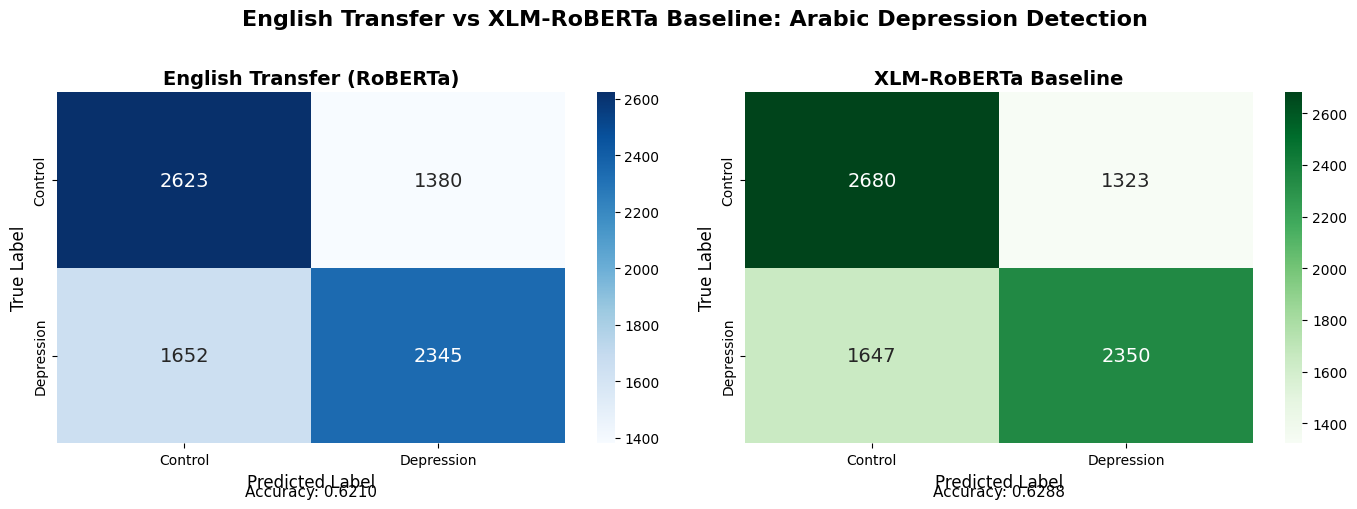

In [ ]:
# ============================================================
# CONFUSION MATRICES VISUALIZATION
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Use SAVED predictions for transfer (trainer was deleted)
transfer_y_pred = transfer_preds.predictions.argmax(-1)
transfer_y_true = transfer_preds.label_ids

# Get predictions for baseline (trainer still exists)
baseline_preds = base_trainer.predict(xlm_val_dataset)
baseline_y_pred = baseline_preds.predictions.argmax(-1)
baseline_y_true = baseline_preds.label_ids

# Plot Transfer confusion matrix
cm_transfer = confusion_matrix(transfer_y_true, transfer_y_pred)
sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Control', 'Depression'],
            yticklabels=['Control', 'Depression'],
            annot_kws={'size': 14})
axes[0].set_title('English Transfer (RoBERTa)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
transfer_acc = (cm_transfer[0,0] + cm_transfer[1,1]) / cm_transfer.sum()
axes[0].text(0.5, -0.15, f'Accuracy: {transfer_acc:.4f}',
             transform=axes[0].transAxes, ha='center', fontsize=11)

# Plot Baseline confusion matrix
cm_baseline = confusion_matrix(baseline_y_true, baseline_y_pred)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Control', 'Depression'],
            yticklabels=['Control', 'Depression'],
            annot_kws={'size': 14})
axes[1].set_title('XLM-RoBERTa Baseline', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
baseline_acc = (cm_baseline[0,0] + cm_baseline[1,1]) / cm_baseline.sum()
axes[1].text(0.5, -0.15, f'Accuracy: {baseline_acc:.4f}',
             transform=axes[1].transAxes, ha='center', fontsize=11)

plt.suptitle('English Transfer vs XLM-RoBERTa Baseline: Arabic Depression Detection',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save figure
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
print("✓ Confusion matrices saved to 'confusion_matrices.png'")

plt.show()